<H1> TP DEEP LEARNING LAHSIKI WALID </H1>

# Reconnaissance de chiffres manuscrits à l'aide de Keras et TensorFlow

Un modèle d'apprentissage profond pour obtenir une performance proche de l'état de l'art sur l'ensemble de données manuscrites du MNIST via Keras avec TensorFlow.

### Ensemble de données MNIST

Cet ensemble de données a été construit à partir d'un certain nombre d'ensembles de données de documents numérisés disponibles auprès du National Institute of Standards and Technology (NIST). Ces images ont été normalisées en taille et centrées. Chaque image est dans un carré de 28x28 (784 pixels). 60 000 images ont été utilisées pour entraîner un modèle et 10 000 pour le tester. D'excellents résultats permettent d'obtenir une erreur de prédiction de 1 %. Les résultats de pointe sont d'environ 0,2 %, ce qui pourrait être obtenu avec un grand réseau neuronal convolutif.

## Visualisation des Données

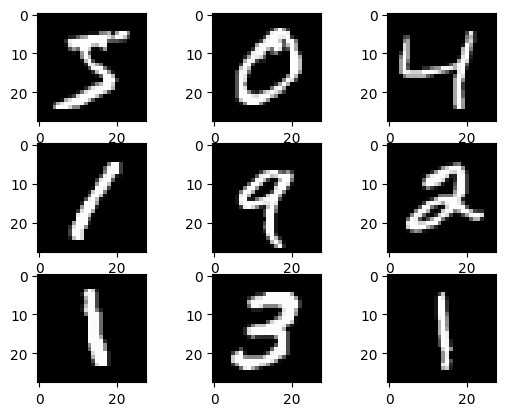

In [20]:
# Importer les bibliothèques nécessaires
from keras.datasets import mnist 
from matplotlib import pyplot 

# Charger les données MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

# Créer une grille d'images 3x3 pour la comparaison
for i in range(0, 9): 
    # Configurer la disposition en sous-plots 3x3
    pyplot.subplot(330 + 1 + i) 
    
    # Afficher l'image en niveaux de gris
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))

# Afficher la grille d'images
pyplot.show()


## Modèle de base avec perceptrons multicouches

Nous commençons par un modèle de base afin de pouvoir comparer notre réseau neuronal convolutif que nous utiliserons plus tard.

Pour créer un modèle de perceptron multicouche, nous aplatissons nos images de 28 x 28 pixels en un seul vecteur de 784 longueurs pour chaque image.

Nous modifions ensuite les valeurs d'échelle de gris de 0-255 à 0-1 pour faciliter les choses sur notre réseau neuronal. (Normalisation)

Enfin, nous changeons les catégories 1 à 9 en une matrice binaire.

La structure actuelle de notre réseau neuronal est la suivante :

**Couche visible (784 entrées) >> Couche cachée (784 neurones) >> Couche de sortie (10 sorties)**

In [21]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils

# Fixer une graine aléatoire pour la reproductibilité
seed = 7
np.random.seed(seed)

# Charger les données MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Aplatir les images 28*28 en vecteurs de 784 pour chaque image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

# Normaliser les entrées de 0-255 à 0-1
X_train = X_train / 255
X_test = X_test / 255

# Encoder en one-hot les étiquettes de sortie
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# Définir le modèle de base
def baseline_model():
    # Créer le modèle
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    
    # Compiler le modèle
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# Construire le modèle
model = baseline_model()

# Entraîner le modèle
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Évaluation finale du modèle
scores = model.evaluate(X_test, y_test, verbose=0)
print("Erreur de base : %.2f%%" % (100 - scores[1] * 100))


Epoch 1/10
300/300 - 4s - loss: 0.2786 - accuracy: 0.9201 - val_loss: 0.1343 - val_accuracy: 0.9618 - 4s/epoch - 15ms/step
Epoch 2/10
300/300 - 3s - loss: 0.1103 - accuracy: 0.9682 - val_loss: 0.0939 - val_accuracy: 0.9717 - 3s/epoch - 11ms/step
Epoch 3/10
300/300 - 4s - loss: 0.0716 - accuracy: 0.9794 - val_loss: 0.0783 - val_accuracy: 0.9766 - 4s/epoch - 12ms/step
Epoch 4/10
300/300 - 3s - loss: 0.0502 - accuracy: 0.9854 - val_loss: 0.0733 - val_accuracy: 0.9770 - 3s/epoch - 11ms/step
Epoch 5/10
300/300 - 3s - loss: 0.0371 - accuracy: 0.9894 - val_loss: 0.0668 - val_accuracy: 0.9789 - 3s/epoch - 11ms/step
Epoch 6/10
300/300 - 3s - loss: 0.0265 - accuracy: 0.9936 - val_loss: 0.0726 - val_accuracy: 0.9759 - 3s/epoch - 11ms/step
Epoch 7/10
300/300 - 3s - loss: 0.0208 - accuracy: 0.9947 - val_loss: 0.0615 - val_accuracy: 0.9808 - 3s/epoch - 11ms/step
Epoch 8/10
300/300 - 3s - loss: 0.0135 - accuracy: 0.9971 - val_loss: 0.0611 - val_accuracy: 0.9808 - 3s/epoch - 11ms/step
Epoch 9/10
300/3

## Réseau neuronal convolutif simple pour MNIST

Comme prévu, nous avons obtenu une erreur d’environ 1 à 2 %, ce qui est formidable. Cependant, nous pouvons faire mieux. Ici, nous profitons de la capacité de Kera à créer des réseaux de neurones convolutifs. Nous utiliserons tous les aspects d'une implémentation CNN moderne, y compris les couches convolutives, les couches de pooling et les couches d'abandon.

Voici nos modifications pour le modèle de base :
1. Nous ajoutons une couche convolutive avec 32 cartes de caractéristiques, d'une taille de 5 x 5. C'est également notre couche d'entrée qui attend l'ajout d'images.
2. Nous définissons ensuite une taille de pool de 2 x 2.
3. Nous supprimons au hasard 20 % de nos neurones pour réduire le taux de surapprentissage.
4. Nous aplatissons ensuite nos données.
5. Nous ajoutons 128 neurones avec une fonction d'activation redresseur comme ci-dessus.
6. Enfin, nous utilisons 10 neurones pour les 10 classes de prédiction avec une fonction d'activation softmax pour générer une prédiction de type probabilité pour chaque classe.

La structure actuelle de notre réseau neuronal est la suivante :

**Couche visible (1x28x28 entrées) >> Couche convolutive (32 cartes, 5x5) >> Couche de pooling maximale (2x2) >> Couche d'abandon (20 %) >> Couche d'aplatissement >> Couche cachée (128 neurones) >> Couche de sortie (10 sorties)**

In [22]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import np_utils
from keras import backend as K

# Définir le format des données d'image en fonction du backend Keras
if K.image_data_format() == 'channels_first':
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

# Charger et prétraiter les données
def preprocess_data(X_train, X_test, y_train, y_test):
    # Remodeler et normaliser les données d'entrée
    X_train = X_train.reshape(X_train.shape[0], *input_shape).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], *input_shape).astype('float32')
    X_train /= 255
    X_test /= 255

    # Encoder en one-hot les étiquettes de sortie
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    return X_train, X_test, y_train, y_test

# Définir le modèle CNN en utilisant l'API fonctionnelle
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compiler le modèle
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Entraîner le modèle
def train_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=200):
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

# Évaluer et afficher les performances du modèle
def evaluate_model(model, X_test, y_test):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Erreur du CNN : {:.2f}%".format(100 - scores[1] * 100))

def main():
    # Fixer une graine aléatoire pour la reproductibilité
    seed = 7
    np.random.seed(seed)

    # Charger l'ensemble de données MNIST
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Prétraiter les données
    X_train, X_test, y_train, y_test = preprocess_data(X_train, X_test, y_train, y_test)

    # Définir le nombre de classes
    num_classes = y_test.shape[1]

    # Créer et entraîner le modèle
    model = create_cnn_model()
    train_model(model, X_train, y_train, X_test, y_test)

    # Évaluer et afficher les performances du modèle
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Epoch 1/10
300/300 [==============================] - 27s 88ms/step - loss: 0.2458 - accuracy: 0.9304 - val_loss: 0.0745 - val_accuracy: 0.9768
Epoch 2/10
300/300 [==============================] - 26s 87ms/step - loss: 0.0724 - accuracy: 0.9786 - val_loss: 0.0519 - val_accuracy: 0.9832
Epoch 3/10
300/300 [==============================] - 27s 89ms/step - loss: 0.0526 - accuracy: 0.9840 - val_loss: 0.0433 - val_accuracy: 0.9857
Epoch 4/10
300/300 [==============================] - 26s 87ms/step - loss: 0.0407 - accuracy: 0.9875 - val_loss: 0.0380 - val_accuracy: 0.9875
Epoch 5/10
300/300 [==============================] - 26s 87ms/step - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.0322 - val_accuracy: 0.9890
Epoch 6/10
300/300 [==============================] - 27s 89ms/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 0.0321 - val_accuracy: 0.9888
Epoch 7/10
300/300 [==============================] - 28s 94ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0316 - val_accuracy:

## Réseau neuronal convolutif plus grand pour le MNIST

Ici, nous avons obtenu une erreur d’environ 1 %, ce qui est excellent. Cependant, nous pouvons atteindre des résultats à la pointe de la technologie. Ici, nous approfondissons et élargissons notre réseau neuronal.

La structure actuelle de notre réseau neuronal est la suivante :

**Couche visible (1x28x28 entrées) >> Couche convolutive (30 cartes, 5x5) >> Couche de regroupement maximale (2x2) >> Couche convolutive (15 cartes, 3x3) >> Couche de regroupement maximale (2x2) >> Couche d'abandon (20 %) >> Couche cachée (128 neurones) >> Couche cachée (50 neurones) >> Couche de sortie (10 sorties)**

In [26]:

# Importer les bibliothèques nécessaires
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K

# Définir le format des données d'image en fonction du backend Keras
K.set_image_data_format('channels_first')  # Utiliser 'channels_first' pour 'th' et 'channels_last' pour 'tf'

# Charger les données MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Remodeler pour [échantillons][pixels][largeur][hauteur]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

# Convertir de int à float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Définir la préparation des données avec des décalages aléatoires
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

# Ajuster les paramètres à partir des données
datagen.fit(X_train)

# Configurer la taille du lot et récupérer un lot d'images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # Créer une grille d'images 3x3
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    
    # Afficher la grille d'images
    pyplot.show()
    
    # Sortir de la boucle après avoir affiché le premier lot
    break


## Conclusion

Grâce à notre capacité à tirer parti d'un réseau neuronal convolutif plus vaste avec Keras, nous avons pu passer d'une erreur de prédiction de 1 à 2 % à moins de 1 %, des résultats proches de l'état de l'art ! Cependant, même avec ce modèle, nous pouvons apporter d'autres améliorations grâce à l'augmentation de l'image et à un GPU beaucoup plus puissant.

### Référence

Ce sont les images que nous avons utilisées.

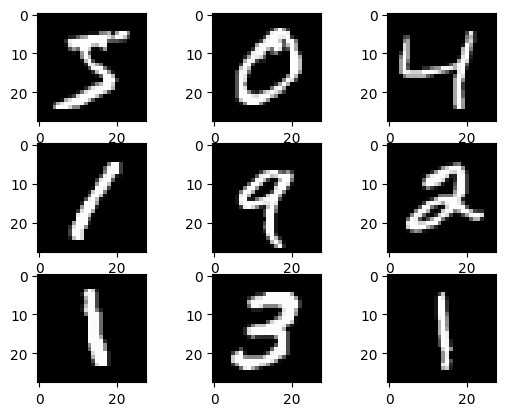

In [27]:
# Importer les bibliothèques nécessaires
from keras.datasets import mnist 
from matplotlib import pyplot 

# Charger les données MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

# Créer une grille d'images 3x3 pour la comparaison
for i in range(0, 9): 
    # Configurer la disposition en sous-plots 3x3
    pyplot.subplot(330 + 1 + i) 
    
    # Afficher l'image en niveaux de gris
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))

# Afficher la grille d'images
pyplot.show()


### Standardisation des Features

Semblable à différentes valeurs scalaires, nous pouvons standardiser différentes images. Le résultat apporté par la standardisation des images est un léger assombrissement et un éclaircissement des différentes images.

In [30]:
# Importer les bibliothèques nécessaires
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K

# Définir le format des données d'image en fonction du backend Keras
K.set_image_data_format('channels_first')  # Utiliser 'channels_first' pour 'th' et 'channels_last' pour 'tf'

# Charger les données MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Remodeler pour [échantillons][pixels][largeur][hauteur]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

# Convertir de int à float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Définir la préparation des données avec des décalages aléatoires
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

# Ajuster les paramètres à partir des données
datagen.fit(X_train)

# Configurer la taille du lot et récupérer un lot d'images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # Créer une grille d'images 3x3
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    
    # Afficher la grille d'images
    pyplot.show()
    
    # Sortir de la boucle après avoir affiché le premier lot
    break


### Blanchiment ZCA

Ici, nous réduisons la redondance de certains pixels afin de mettre en valeur certaines caractéristiques des images. Semblable à l’analyse en composantes principales, nous utilisons ZCA pour les images.

In [32]:
# Importer les bibliothèques nécessaires
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K

# Définir le format des données d'image en fonction du backend Keras
K.set_image_data_format('channels_first')  # Utiliser 'channels_first' pour 'th' et 'channels_last' pour 'tf'

# Charger les données MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Remodeler pour [échantillons][pixels][largeur][hauteur]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

# Convertir de int à float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Définir la préparation des données avec des décalages aléatoires
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

# Ajuster les paramètres à partir des données
datagen.fit(X_train)

# Configurer la taille du lot et récupérer un lot d'images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # Créer une grille d'images 3x3
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    
    # Afficher la grille d'images
    pyplot.show()
    
    # Sortir de la boucle après avoir affiché le premier lot
    break


### Rotations aléatoires

Différentes personnes écrivent sous différents angles. Ici, nous faisons pivoter les images de manière aléatoire jusqu'à 90 degrés.

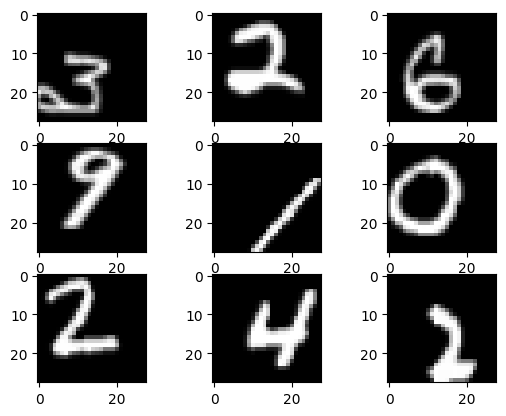

In [34]:
# Importer les bibliothèques nécessaires
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K

# Charger les données MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Remodeler pour [échantillons][pixels][largeur][hauteur]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

# Convertir de int à float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Définir la préparation des données avec des décalages aléatoires
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

# Ajuster les paramètres à partir des données
datagen.fit(X_train)

# Configurer la taille du lot et récupérer un lot d'images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # Créer une grille d'images 3x3
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    
    # Afficher la grille d'images
    pyplot.show()
    
    # Sortir de la boucle après avoir affiché le premier lot
    break


### Changements aléatoires

Parfois, les chiffres ne sont pas exactement centrés. Ici, nous décalons les nombres de manière aléatoire pour qu'ils soient légèrement décentrés.

In [36]:
# Importer les bibliothèques nécessaires
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

# Charger les données MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Remodeler pour [échantillons][pixels][largeur][hauteur]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

# Convertir de int à float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Définir la préparation des données avec des décalages aléatoires
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

# Ajuster les paramètres à partir des données
datagen.fit(X_train)

# Configurer la taille du lot et récupérer un lot d'images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # Créer une grille d'images 3x3
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    
    # Afficher la grille d'images
    pyplot.show()
    
    # Sortir de la boucle après avoir affiché le premier lot
    break
